In [ ]:
import sklearn
import scipy.stats
import pandas as pd
import numpy as np

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import math

In [ ]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.1 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

In [ ]:
import seaborn as sns

## Loadaing data and saving data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Proximity correction/PSF"

/content/drive/My Drive/Proximity correction/PSF


In [ ]:
df6 = pd.read_csv('ya_d6.csv', header=0)
df9 = pd.read_csv('ya_d9.csv', header=0)
df31 = pd.read_csv('ya_d31.csv', header=0)
df7 = pd.read_csv('ya_d7.csv', header=0)
df11 = pd.read_csv('ya_d11.csv', header=0)
df12 = pd.read_csv('ya_d12.csv', header=0)
df18 = pd.read_csv('ya_d18.csv', header=0)

In [ ]:
df18.head(3)

,Unnamed: 0,Radius,lnfr,Thickness,SiO2,Orientation,Dopant,Resistivity,EHT,Aperture,dopant_type,excitation_energy
0,0,0.017841,6.67414,525,4,111,phospor,22,20,7.5,n_type,173
1,1,0.015848,6.56878,525,4,111,phospor,22,20,7.5,n_type,173
2,2,0.015948,6.47347,525,4,111,phospor,22,20,7.5,n_type,173


In [ ]:
df18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         360 non-null    int64  
 1   Radius             360 non-null    float64
 2   lnfr               360 non-null    float64
 3   Thickness          360 non-null    int64  
 4   SiO2               360 non-null    int64  
 5   Orientation        360 non-null    int64  
 6   Dopant             360 non-null    object 
 7   Resistivity        360 non-null    int64  
 8   EHT                360 non-null    int64  
 9   Aperture           360 non-null    float64
 10  dopant_type        360 non-null    object 
 11  excitation_energy  360 non-null    int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 33.9+ KB


In [ ]:
def save_dfs(df_list, filenames):
    for filename, df_data in zip(filenames, df_list):
        df_data.to_csv(filename)

In [ ]:
def read_dfs(filenames):
    df_list = []
    for filename in filenames:
        df_data = pd.read_csv(filename, header=0)
        df_list.append(df_data)
    return df_list

## Data Processing

In [ ]:
df = pd.concat([df6, df9, df31, df7, df11, df12, df18]).reset_index(drop=True)
df['Orientation'] = df['Orientation'].astype('object')

In [ ]:
df = df.drop(['EHT', 'Aperture'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Radius       2430 non-null   float64
 1   lnfr         2430 non-null   float64
 2   Thickness    2430 non-null   int64  
 3   SiO2         2430 non-null   object 
 4   Orientation  2430 non-null   object 
 5   Dopant       2430 non-null   object 
 6   Resistivity  2430 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 133.0+ KB


In [ ]:
def process_single_df(df, numeric_features):
    scaler = StandardScaler()

    X = df.drop(['lnfr'], axis=1)
    y = df['lnfr']

    # splitting dataframe on train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    radii = X_test['Radius']

    # scaling
    X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = scaler.transform(X_test[numeric_features])
    return X_train, X_test, y_train, y_test, scaler, radii

In [ ]:
# df2 = df.copy(deep=True)
# df2 = df2[df2['Radius'] > 0.5]
X_train, X_test, y_train, y_test, scaler, radii = process_single_df(df, ['Thickness', 'Resistivity', 'Radius'])

## Predictions

In [ ]:
def percent_error(y_test, preds):
    percents = []

    for i,y_i in enumerate(y_test):
        percent = math.fabs((y_i-preds[i]) / y_i) * 100
        percents.append(percent)
    return sum(percents) / len(percents)

In [ ]:
def train_and_predict(X_train, X_test, y_train, y_test, cat_features):
    # loading model and training it
    model = CatBoostRegressor(random_state=42, cat_features = cat_features, loss_function='MAE', verbose=False)
    model.fit(X_train, y_train)

    # metrics evaluation on the test set
    preds = model.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    ard = percent_error(y_test, preds)

    print("RMSE: {:.3}".format(rmse))
    print("ARD: {:.3}".format(ard))
    return rmse, ard, preds, model


In [ ]:
rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test, ['Orientation', 'Dopant', 'dopant_type'])

RMSE: 0.265
ARD: 9.94


In [ ]:
def build_pred_df(y_test, preds, radii):
    df_preds = pd.DataFrame()
    df_preds['y_test'] = y_test.reset_index(drop=True)
    df_preds['preds'] = pd.Series(preds)
    df_preds['Radius'] = radii.reset_index(drop=True)

    return df_preds.sort_values(by=['Radius'])

In [ ]:
df_preds = build_pred_df(y_test, preds, radii)

NameError: ignored

In [ ]:
df_preds

,y_test,preds,Radius
10,6.603266,6.931780,0.000000
597,6.507956,6.931780,0.000000
197,4.116817,3.498626,0.007136
465,3.949763,3.498626,0.007334
392,3.470190,3.498626,0.008630
...,...,...,...
362,-4.650073,-4.671678,2.262534
319,-4.582331,-4.604231,2.268365
604,-4.701437,-4.700912,2.312764
288,-4.703160,-4.677724,2.336590


## Vizualization

In [ ]:
def draw_data(df):
    x = df['Radius']
    y = df['lnfr']

    # drawing a figure
    fig, axes = plt.subplots(1,1, figsize = (9,6))

    axes.plot(x, y, marker="o");
    axes.set_xlabel('Radius');
    axes.set_ylabel('PSF');

In [ ]:
def draw_psf(df_preds):
    x = df_preds['Radius']
    y_p = df_preds['preds']
    y_t = df_preds['y_test']

    # drawing a figure
    fig, axes = plt.subplots(1,1, figsize = (9,6))

    axes.plot(x, y_p, marker="o");
    axes.plot(x, y_t, marker="o")
    axes.set_xlabel('Radius');
    axes.set_ylabel('PSF');
    axes.legend(['Predictions', 'Experiment']);

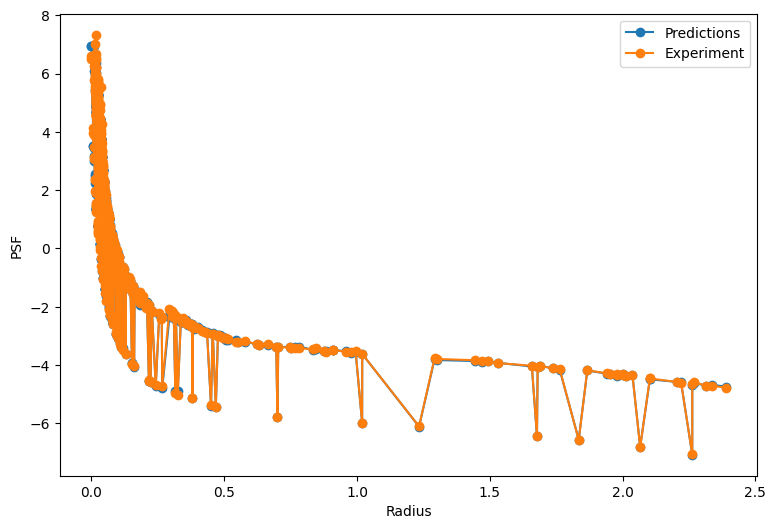

In [ ]:
draw_psf(df_preds)

In [ ]:
def draw_index(preds, y_test):
    #building pred Series and replacing its index with idex from sorted y_test
    preds_s = pd.Series(preds)
    preds_s.index = y_test.index

    # sorting predictions and y_test
    y_t = y_test.sort_values()
    preds_s = preds_s[y_t.index]

    # resetin index to draw a figure
    preds_s = preds_s.reset_index(drop=True)
    y_t = y_t.reset_index(drop=True)

    fig, axes = plt.subplots(1,1, figsize = (9,6))

    axes.plot(preds_s, marker="o");
    axes.plot(y_t, marker="o")
    axes.set_xlabel('index of the sample');
    axes.set_ylabel('PSF');
    axes.legend(['Predictions', 'Measured']);

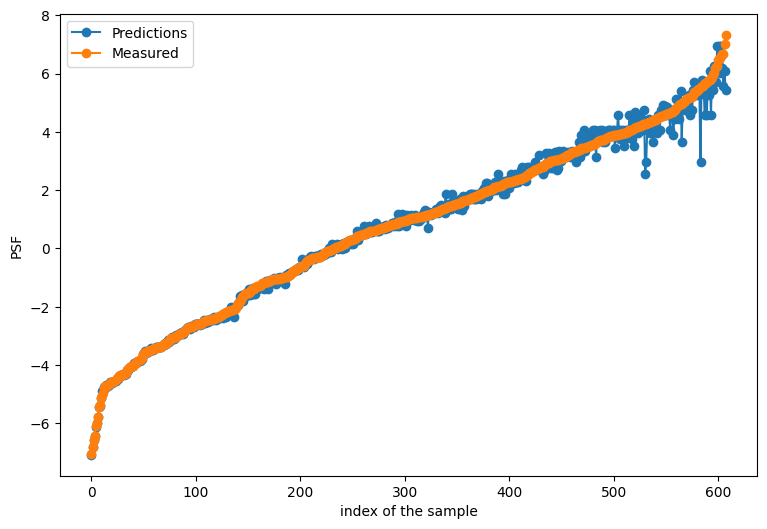

In [ ]:
draw_index(preds, y_test)

In [ ]:
def draw_feature_importance(model):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    plt.title('Feature Importance')

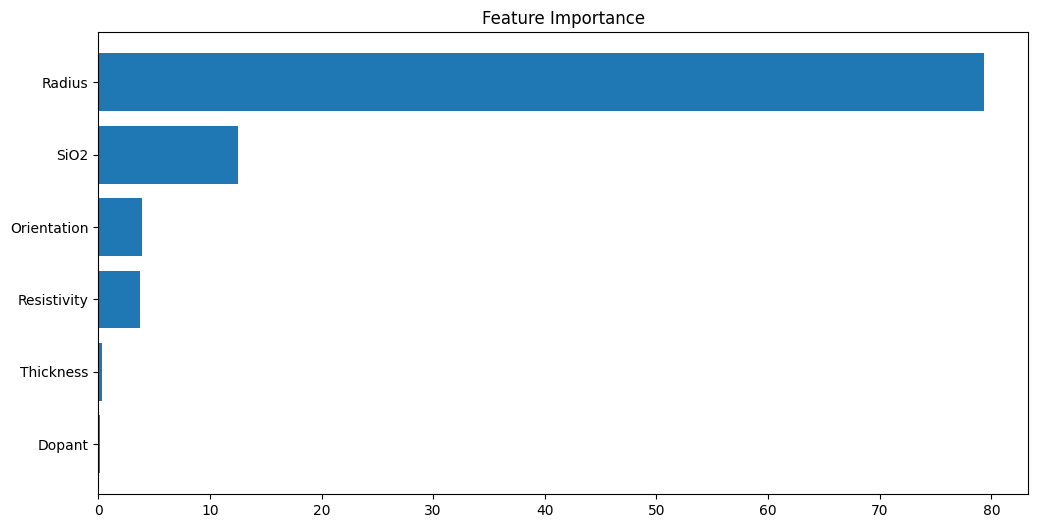

In [ ]:
draw_feature_importance(model)

## Prediction for the specific dopant

In [ ]:
def prepare_dopant_data(train, test, numeric_features):

    # preparing dataframes
    # train['Orientation'] = train['Orientation'].astype('object')
    # test['Orientation'] = test['Orientation'].astype('object')

    # train = train.drop(['EHT', 'Aperture'], axis=1)
    # test = test.drop(['EHT', 'Aperture'], axis=1)

    # shuffling
    train = train.sample(frac=1)
    test = test.sample(frac=1)
    radii = test['Radius']

    #scaling
    scaler = StandardScaler()
    train[numeric_features] = scaler.fit_transform(train[numeric_features])
    test[numeric_features] = scaler.transform(test[numeric_features])

    X_train = train.drop(['lnfr'], axis=1)
    X_test = test.drop(['lnfr'], axis=1)
    y_train = train['lnfr']
    y_test = test['lnfr']

    return X_train, X_test, y_train, y_test, scaler, radii

In [ ]:
train = pd.concat([df6, df9, df31, df7, df12, df18]).copy(deep=True)
train = df18.copy(deep=True)
# train = train.query('Radius < 0.5')
# train = train[train['Radius'] > 0.5]
test = df11.copy(deep=True)
# test = test.query('Radius < 0.5')
# test = test[test['Radius'] > 0.5]
X_train, X_test, y_train, y_test, scaler, radii = prepare_dopant_data(train, test, ['Thickness', 'Resistivity', 'Radius'])

In [ ]:
test.tail()

,Radius,lnfr,Thickness,SiO2,Orientation,Dopant,Resistivity,EHT,Aperture
342,2.265135,-4.631487,525,nativ,111,phospor,0.003,20,7.5
343,2.294317,-4.666414,525,nativ,111,phospor,0.003,20,7.5
344,2.334409,-4.701437,525,nativ,111,phospor,0.003,20,7.5
345,2.353421,-4.735891,525,nativ,111,phospor,0.003,20,7.5
346,2.387995,-4.770982,525,nativ,111,phospor,0.003,20,7.5


In [ ]:
rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test)

RMSE: 0.636
ARD: 49.3


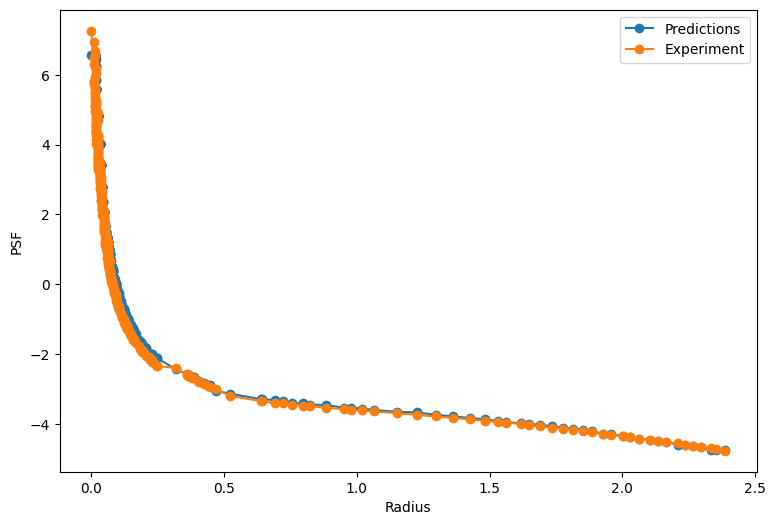

In [ ]:
df_preds = build_pred_df(y_test, preds, radii)
# draw_index(preds, y_test)
draw_psf(df_preds)

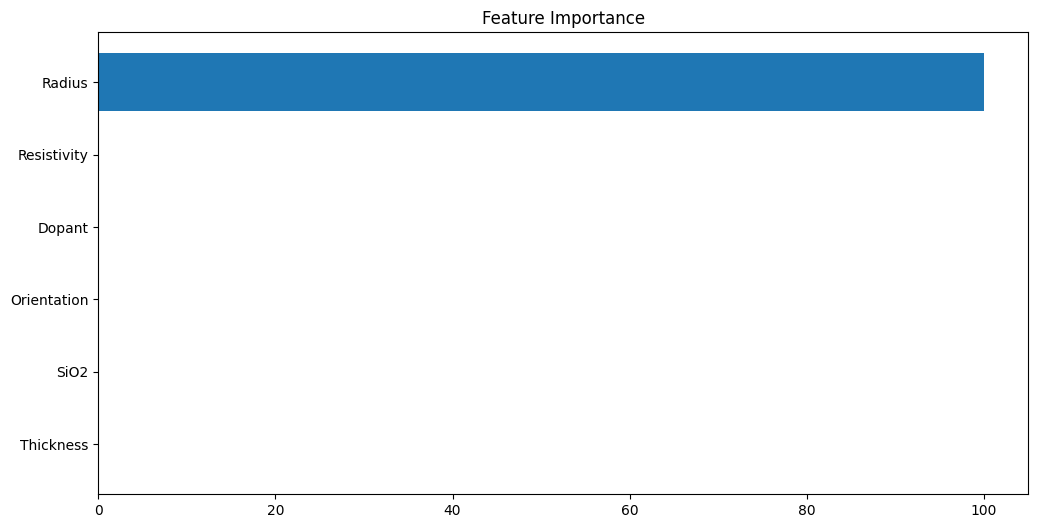

In [ ]:
draw_feature_importance(model)

## Data Analysis

In [ ]:
df6_analysis = df6.copy(deep=True)
df6_analysis = df6_analysis.query('Radius > 0.03 and Radius < 0.035')
df6_analysis.iloc[0:10]

,Radius,lnfr,Thickness,SiO2,Orientation,Dopant,Resistivity,EHT,Aperture,dopant_type,excitation_energy
66,0.030902,3.912023,500,4,111,bor,0.001,20,7.5,p_type,76
78,0.030902,3.570274,500,4,111,bor,0.001,20,7.5,p_type,76
79,0.030902,3.544298,500,4,111,bor,0.001,20,7.5,p_type,76
80,0.030902,3.504092,500,4,111,bor,0.001,20,7.5,p_type,76
82,0.030902,3.470190,500,4,111,bor,0.001,20,7.5,p_type,76
86,0.030902,3.401197,500,4,111,bor,0.001,20,7.5,p_type,76
87,0.030902,3.379218,500,4,111,bor,0.001,20,7.5,p_type,76
88,0.030902,3.374880,500,4,111,bor,0.001,20,7.5,p_type,76
89,0.030902,3.357712,500,4,111,bor,0.001,20,7.5,p_type,76
90,0.030902,3.316040,500,4,111,bor,0.001,20,7.5,p_type,76


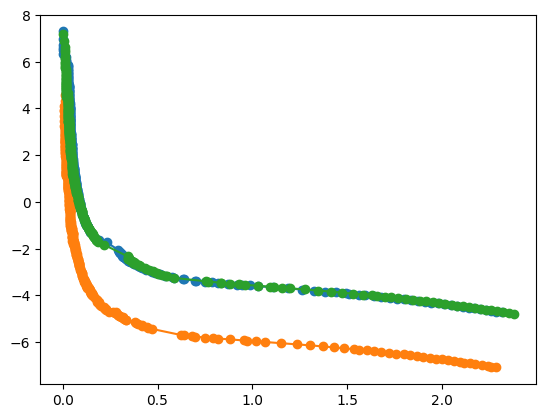

In [ ]:
x1 = df9['Radius']
y1 = df9['lnfr']

x2 = df31['Radius']
y2 = df31['lnfr']

x3 = df6['Radius']
y3 = df6['lnfr']

plt.plot(x1, y1, marker = 'o')
plt.plot(x2, y2, marker = 'o')
plt.plot(x3, y3, marker = 'o')

## Processing identical radii values

In our dataset, we have observed points that significantly reduce the quality of our prediction model. This issue arises because multiple values of the PSF are obtained for the same radius. This discrepancy is caused by inaccuracies in the measurements.

Consequently, we encounter situations where we have several samples in the dataset with the same radius but different target values. This inconsistency in the PSF values for identical radii adversely affects the quality of our prediction model.

As a result, we have observed a significant decrease in the accuracy of our model specifically for the radii with duplicate PSF values.

To address this issue and improve the quality of our predictions, we need to carefully examine and resolve the inaccuracies in the PSF measurements for the affected radii. By ensuring consistent and accurate PSF values for each radius, we can enhance the performance of our prediction model.

In [ ]:
def drop_duplicate_radii(df_input):
    """
        Removinf samples with identical radii and different PSF
    """
    df = df_input.copy(deep=True).reset_index(drop=True)

    radii = df['Radius'].unique().tolist()
    print(radii[0:10])

    new_psf = []
    for r in radii:
        df_radius = df.query('Radius == {}'.format(r))
        mean_psf = df_radius['lnfr'].mean()
        new_psf.append(mean_psf)

    data = list(zip(radii, new_psf))
    df_reduced = pd.DataFrame(data, columns=['Radius', 'lnfr'])
    columns = ['Thickness', 'SiO2', 'Orientation', 'Dopant', 'Resistivity', 'EHT', 'Aperture']
    for column in columns:
        df_reduced[column] = df.loc[0, column]

    return df_reduced

In [ ]:
df6 = pd.read_csv('ya_d6.csv', header=0)
df9 = pd.read_csv('ya_d9.csv', header=0)
df31 = pd.read_csv('ya_d31.csv', header=0)
df7 = pd.read_csv('ya_d7.csv', header=0)
df11 = pd.read_csv('ya_d11.csv', header=0)
df12 = pd.read_csv('ya_d12.csv', header=0)
df18 = pd.read_csv('ya_d18.csv', header=0)

In [ ]:
df6_reduced = drop_duplicate_radii(df6)
df6_reduced

[0.0, 0.0062571651728723, 0.010983598994121, 0.0092705808485565, 0.0109400419197143, 0.0112696781048676, 0.0122443438530844, 0.0127661529728458, 0.0131590492849591, 0.0141047395886939]


,Radius,lnfr,Thickness,SiO2,Orientation,Dopant,Resistivity,EHT,Aperture
0,0.000000,7.207860,500,4,111,bor,0.001,20,7.5
1,0.006257,6.871388,500,4,111,bor,0.001,20,7.5
2,0.010984,6.620073,500,4,111,bor,0.001,20,7.5
3,0.009271,6.514713,500,4,111,bor,0.001,20,7.5
4,0.010940,6.419403,500,4,111,bor,0.001,20,7.5
...,...,...,...,...,...,...,...,...,...
151,2.262534,-4.650073,500,4,111,bor,0.001,20,7.5
152,2.292027,-4.685555,500,4,111,bor,0.001,20,7.5
153,2.324981,-4.720481,500,4,111,bor,0.001,20,7.5
154,2.353962,-4.755504,500,4,111,bor,0.001,20,7.5


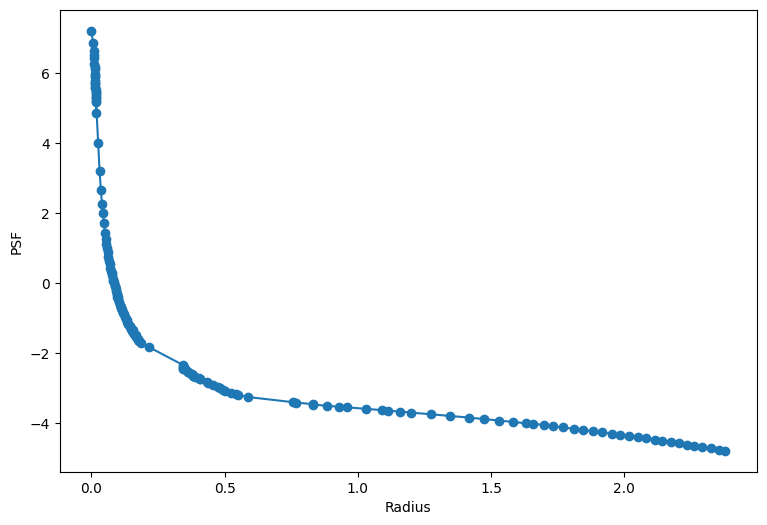

In [ ]:
draw_data(df6_reduced)

In [ ]:
dfs = [df6, df7, df11, df12, df31, df18]

## Processed data prediction (removed duplicates)

### All experimental samples

In [ ]:
dfs = [df6, df9, df31, df7, df11, df12, df18]
dfs_processed = []
for df in dfs:
    df_new = drop_duplicate_radii(df)
    dfs_processed.append(df_new)

dfs2 = pd.concat(dfs_processed)

In [ ]:
dfs_processed

[       Radius      lnfr  Thickness  SiO2  Orientation Dopant  Resistivity  \
 0    0.000000  7.207860        500     4          111    bor        0.001   
 1    0.006257  6.871388        500     4          111    bor        0.001   
 2    0.010984  6.620073        500     4          111    bor        0.001   
 3    0.009271  6.514713        500     4          111    bor        0.001   
 4    0.010940  6.419403        500     4          111    bor        0.001   
 ..        ...       ...        ...   ...          ...    ...          ...   
 151  2.262534 -4.650073        500     4          111    bor        0.001   
 152  2.292027 -4.685555        500     4          111    bor        0.001   
 153  2.324981 -4.720481        500     4          111    bor        0.001   
 154  2.353962 -4.755504        500     4          111    bor        0.001   
 155  2.379583 -4.789958        500     4          111    bor        0.001   
 
      EHT  Aperture  
 0     20       7.5  
 1     20       7.

In [ ]:
df = dfs2.drop(['EHT', 'Aperture'], axis=1)
X_train, X_test, y_train, y_test, scaler, radii = process_single_df(df)

In [ ]:
rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test)

RMSE: 0.209
ARD: 5.61


In [ ]:
df_preds = build_pred_df(y_test, preds, radii)

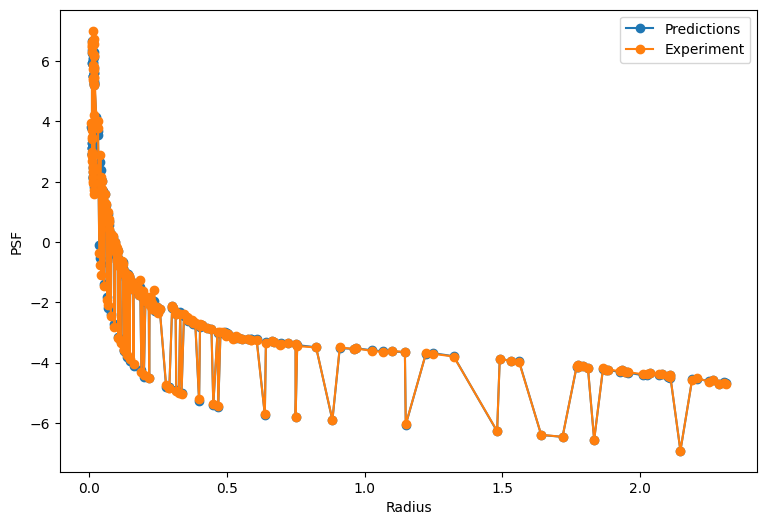

In [ ]:
draw_psf(df_preds)

### Dopant prediction

In [ ]:
train = pd.concat([dfs_processed[4], dfs_processed[3]])
train = train.drop(['EHT', 'Aperture', 'Dopant', 'Orientation', 'dopant_type'], axis=1)
test = dfs_processed[6]
test = test.drop(['EHT', 'Aperture', 'Dopant', 'Orientation', 'dopant_type'], axis=1)
X_train, X_test, y_train, y_test, scaler, radii = prepare_dopant_data(train, test, ['Radius', 'SiO2', 'excitation_energy', 'Thickness', 'Resistivity'])

In [ ]:
rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test, [])

RMSE: 0.348
ARD: 52.9


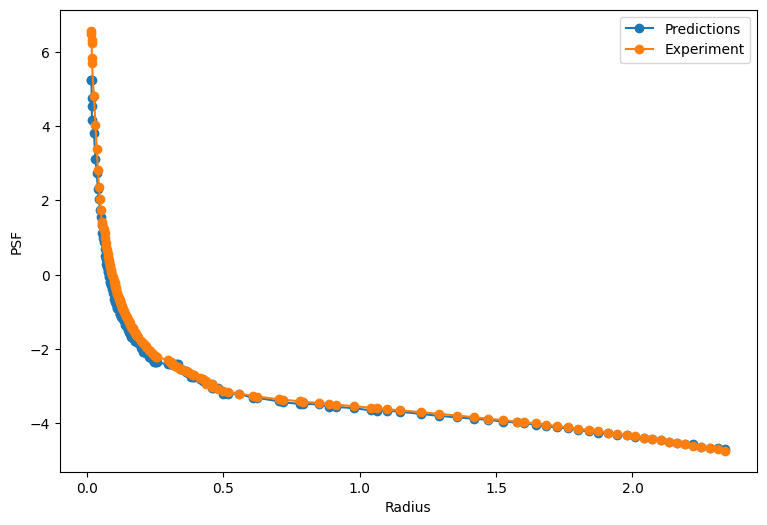

In [ ]:
df_preds = build_pred_df(y_test, preds, radii)
# draw_index(preds, y_test)
draw_psf(df_preds)

## Update samples features with physical data

In [ ]:
dfs = [df6, df9, df31, df7, df11, df12, df18]
files_names = ['ya_d6.csv', 'ya_d9.csv', 'ya_d31.csv', 'ya_d7.csv', 'ya_d11.csv', 'ya_d12.csv', 'ya_d18.csv']

In [ ]:
def change_values(data, categorical_column, mapping):
    data[categorical_column] = data[categorical_column].map(mapping)
    return data

In [ ]:
def add_column(data, column, value):
    data[column] = value
    return data

In [ ]:
def get_dopant_name(data):
    return data['Dopant'].iloc[0]

In [ ]:
"""
 Mappings and new features
"""
SiO2_mapping = {"nativ": 4, "90nm": 90}

excitation_energy = {"bor": 76, "phospor": 173, "antimony": 487, "arsen": 346}
dopant_type = {"bor": "p_type", "phospor": "n_type", "antimony": "n_type", "arsen": "n_type"}

In [ ]:
"""
Updating data and saving dataframes
This update s performed for the data with dropped duplicated radii (dfs_processed)
"""
files_names_u = ['ya_d6u.csv', 'ya_d9u.csv', 'ya_d31u.csv', 'ya_d7u.csv', 'ya_d11u.csv', 'ya_d12u.csv', 'ya_d18u.csv']

for df,filename in zip(dfs_processed, files_names_u):
    change_values(df, "SiO2", SiO2_mapping)
    dopant = get_dopant_name(df)
    df['dopant_type'] = dopant_type[dopant]
    df['excitation_energy'] = excitation_energy[dopant]
    df.to_csv(filename)

In [ ]:
dfs_processed[6].head(3)

,Radius,lnfr,Thickness,SiO2,Orientation,Dopant,Resistivity,EHT,Aperture,dopant_type,excitation_energy
0,0.017841,5.695428,525,NaN,111,phospor,22,20,7.5,n_type,173
1,0.015848,6.568780,525,NaN,111,phospor,22,20,7.5,n_type,173
2,0.015948,6.473470,525,NaN,111,phospor,22,20,7.5,n_type,173


## Prediction for the expanded data

### Prediction for the updated dataset

In [ ]:
pred_df = pd.concat(dfs_processed).copy(deep=True)
pred_df = pred_df.drop(['EHT', 'Aperture', 'Dopant', 'Orientation', 'dopant_type'], axis=1)
X_train, X_test, y_train, y_test, scaler, radii = process_single_df(pred_df, ['Radius', 'SiO2', 'excitation_energy', 'Thickness', 'Resistivity'])

In [ ]:
rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test, [])

RMSE: 0.209
ARD: 4.49


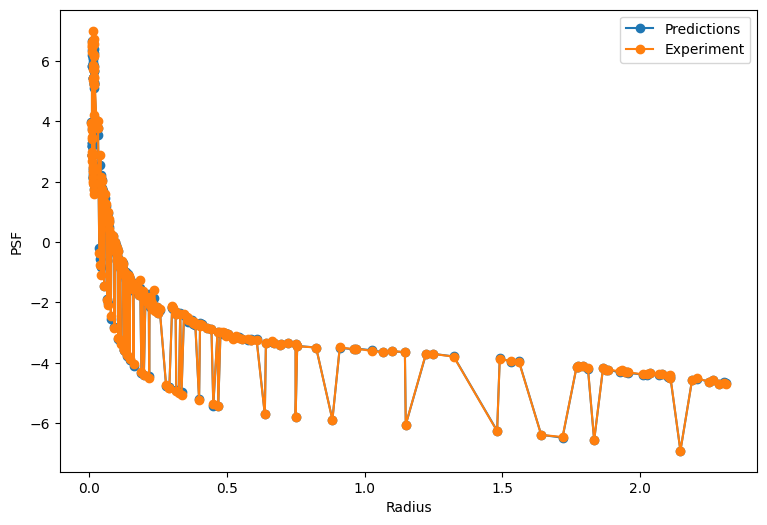

In [ ]:
df_preds = build_pred_df(y_test, preds, radii)
draw_psf(df_preds)

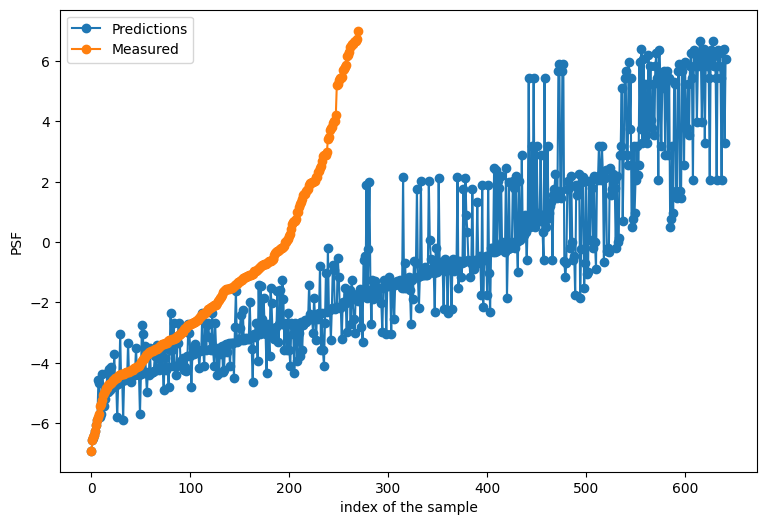

In [ ]:
draw_index(preds, y_test)

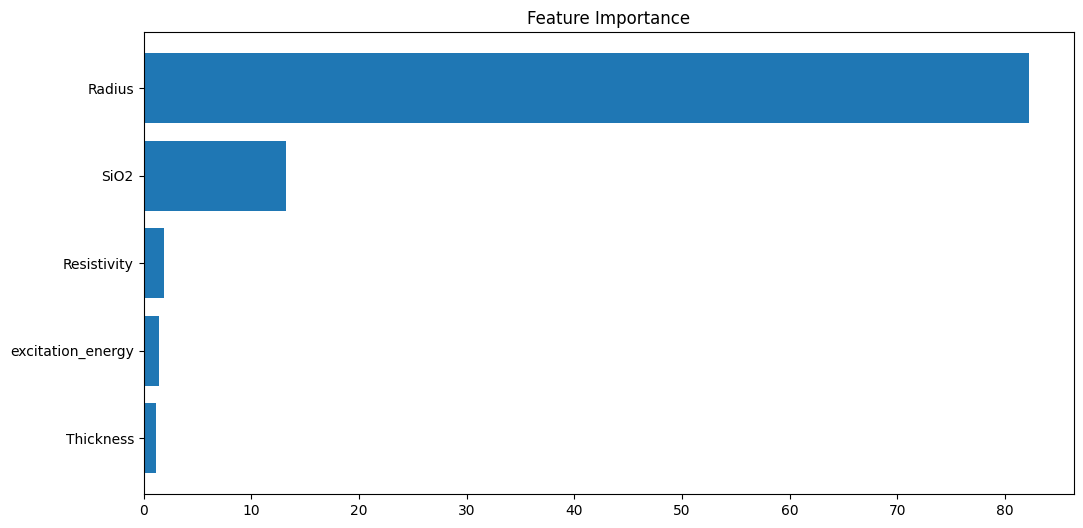

In [ ]:
draw_feature_importance(model)

### Splitted 90 nm SiO2 prediction

In [ ]:
df31_1 = dfs_processed[2].query('Radius <= 0.5')
df31_2 = dfs_processed[2].query('Radius > 0.5')

In [ ]:
split_dfs = [dfs_processed[4], dfs_processed[1], dfs_processed[2], dfs_processed[0], dfs_processed[5], dfs_processed[6]]
train = pd.concat(split_dfs).copy(deep=True)
train = train.drop(['EHT', 'Aperture'], axis=1)

test = dfs_processed[3]
test = test.drop(['EHT', 'Aperture'], axis=1)

X_train, X_test, y_train, y_test, scaler, radii = prepare_dopant_data(train, test, ['Radius', 'SiO2', 'excitation_energy', 'Thickness', 'Resistivity'])

In [ ]:
rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test, ['Dopant', 'Orientation', 'dopant_type'])

RMSE: 0.361
ARD: 15.8


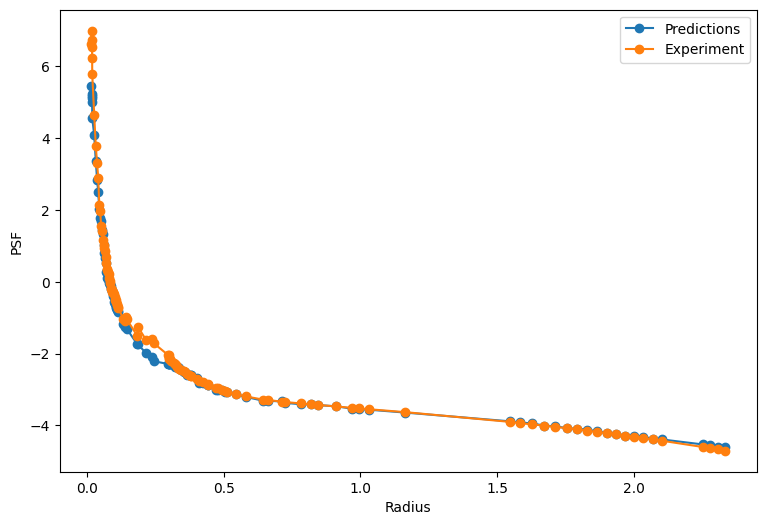

In [ ]:
df_preds = build_pred_df(y_test, preds, radii)
draw_psf(df_preds)

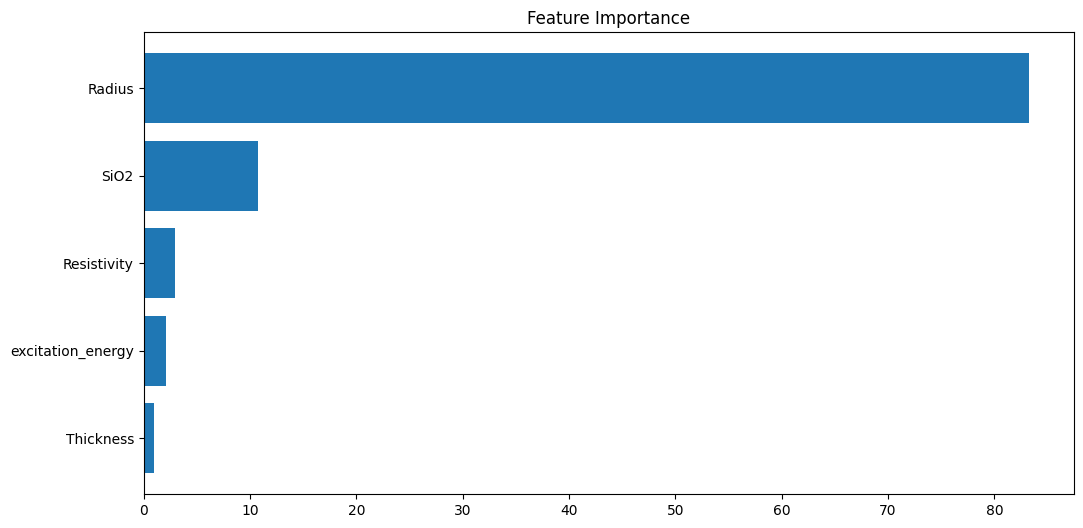

In [ ]:
draw_feature_importance(model)

## Physical features prediction

### Data Processing

In [ ]:
files_names_u = ['ya_d6u.csv', 'ya_d7u.csv', 'ya_d11u.csv', 'ya_d12u.csv', 'ya_d18u.csv']
# files_names_u = ['ya_d6u.csv', 'ya_d7u.csv', 'ya_d11u.csv', 'ya_d12u.csv']

In [ ]:
dfs = []
for filename in files_names_u:
    dfi = pd.read_csv(filename, index_col=0)
    dfs.append(dfi)

In [ ]:
df_n = pd.concat(dfs, axis=0)
df_n.to_csv("concateanted_data.csv")

In [ ]:
dfs[0]['IonPotential'] = 171.8602207638658
dfs[1]['IonPotential'] = 172.2209977359778
dfs[2]['IonPotential'] = 172.0757052180948
dfs[3]['IonPotential'] = 172.0723290709872
dfs[4]['IonPotential'] = 172.0716632577786

In [ ]:
dfs[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 0 to 155
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Radius             156 non-null    float64
 1   lnfr               156 non-null    float64
 2   Thickness          156 non-null    int64  
 3   SiO2               0 non-null      float64
 4   Orientation        156 non-null    int64  
 5   Dopant             156 non-null    object 
 6   Resistivity        156 non-null    float64
 7   EHT                156 non-null    int64  
 8   Aperture           156 non-null    float64
 9   dopant_type        156 non-null    object 
 10  excitation_energy  156 non-null    int64  
 11  IonPotential       156 non-null    float64
dtypes: float64(6), int64(4), object(2)
memory usage: 15.8+ KB


In [ ]:
for i,filename in enumerate(files_names_u):
    dfs[i].to_csv(filename)

In [ ]:
dfs = []
selected_columns = ['Radius', 'lnfr', 'IonPotential']
for filename in files_names_u:
    dfi = pd.read_csv(filename, usecols=selected_columns)
    dfs.append(dfi)

In [ ]:
dfs[4]

,Radius,lnfr,IonPotential
0,0.017841,5.695428,172.071663
1,0.015848,6.568780,172.071663
2,0.015948,6.473470,172.071663
3,0.016991,6.306416,172.071663
4,0.016400,6.232308,172.071663
...,...,...,...
154,2.220357,-4.596006,172.071663
155,2.251816,-4.631487,172.071663
156,2.284167,-4.666414,172.071663
157,2.312764,-4.701437,172.071663


### Adding scattering params

In [ ]:
files_names_u = ['ya_d6u.csv', 'ya_d7u.csv', 'ya_d11u.csv', 'ya_d12u.csv', 'ya_d18u.csv']

In [ ]:
def add_scatter_params(dfi, scatter_params_i):
    dfi['alpha'] = scatter_params_i['alpha']
    dfi['beta'] = scatter_params_i['beta']
    dfi['eta'] = scatter_params_i['eta']
    dfi['nu1'] = scatter_params_i['nu1']
    dfi['nu2'] = scatter_params_i['nu2']
    dfi['gamma1'] = scatter_params_i['gamma1']
    dfi['gamma2'] = scatter_params_i['gamma2']

    return dfi

In [ ]:
ya_d6u_scatter_params = {'alpha': 0.01572,
                         'beta': 0.27829,
                         'eta': 0.12447,
                         'nu1': 0.24752,
                         'nu2': 0.88636,
                         'gamma1' : 0.02065,
                         'gamma2': 1.94804
}

ya_d7u_scatter_params = {'alpha':0.01995,
                         'beta': 0.24823,
                         'eta': 0.14627,
                         'nu1': 0.30806,
                         'nu2': 0.96076,
                         'gamma1' : 0.0172,
                         'gamma2': 1.9003
}

ya_d11u_scatter_params = {'alpha':0.01457,
                         'beta': 0.28736,
                         'eta': 0.09635,
                         'nu1': 0.25931,
                         'nu2': 0.86953,
                         'gamma1' : 0.01972,
                         'gamma2': 1.99745
}

ya_d12u_scatter_params = {'alpha':0.0172,
                         'beta': 0.31701,
                         'eta': 0.09019,
                         'nu1': 0.2158,
                         'nu2': 0.95066,
                         'gamma1' : 0.02476,
                         'gamma2': 2.00273
}

ya_d18u_scatter_params = {'alpha':0.02133,
                         'beta': 0.292681,
                         'eta': 0.09137,
                         'nu1': 0.240978,
                         'nu2': 0.86539,
                         'gamma1' : 0.02728,
                         'gamma2': 1.9313
}

In [ ]:
# adding scattering parameters
dfsu = []
scatter_params_dicts = [ya_d6u_scatter_params, ya_d7u_scatter_params, ya_d11u_scatter_params,
                        ya_d12u_scatter_params, ya_d18u_scatter_params]
for dfi, scatter_params_dict, filename in zip(dfs, scatter_params_dicts, files_names_u):
    dfi = add_scatter_params(dfi, scatter_params_dict)
    dfsu.append(dfi)
    dfi.to_csv(filename)


In [ ]:
df_n = pd.concat(dfsu)

In [ ]:
df_n.head()

,Radius,lnfr,IonPotential,alpha,beta,eta,nu1,nu2,gamma1,gamma2
0,0.000000,7.207860,171.860221,0.01572,0.27829,0.12447,0.24752,0.88636,0.02065,1.94804
1,0.006257,6.871388,171.860221,0.01572,0.27829,0.12447,0.24752,0.88636,0.02065,1.94804
2,0.010984,6.620073,171.860221,0.01572,0.27829,0.12447,0.24752,0.88636,0.02065,1.94804
3,0.009271,6.514713,171.860221,0.01572,0.27829,0.12447,0.24752,0.88636,0.02065,1.94804
4,0.010940,6.419403,171.860221,0.01572,0.27829,0.12447,0.24752,0.88636,0.02065,1.94804


### Analysis of correlations

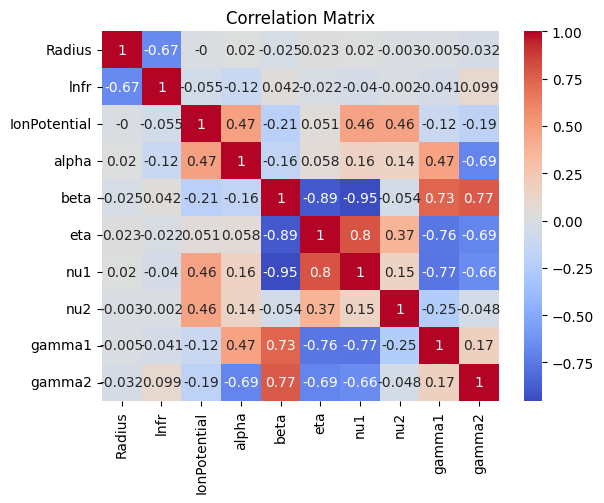

In [ ]:
correlation_matrix = df_n.corr().round(3)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Prediction for the whole dataset

#### Baseline prediction

In [ ]:
df_n = pd.concat(dfs[0:5])

In [ ]:
df_n2 = df_n[df_n['Radius'] > 0.65]

In [ ]:
numeric_columns = ['Radius']
df_nbase = df_n2.drop(['IonPotential', 'alpha', 'beta', 'eta', 'nu1', 'nu2', 'gamma1', 'gamma2'], axis=1)
X_train, X_test, y_train, y_test, scaler, radii = process_single_df(df_nbase, numeric_columns)

rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test, [])

RMSE: 0.0303
ARD: 0.628


In [ ]:
numeric_columns = ['Radius', 'alpha', 'beta', 'eta', 'nu1', 'nu2', 'gamma1', 'gamma2']
df_nbase = df_n.drop(['IonPotential'], axis=1)
X_train, X_test, y_train, y_test, scaler, radii = process_single_df(df_nbase, numeric_columns)

rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test, [])

RMSE: 0.125
ARD: 8.19


#### Full features prediction

In [ ]:
numeric_columns = ['Radius', 'IonPotential', 'alpha', 'beta', 'eta', 'nu1', 'nu2', 'gamma1', 'gamma2']
X_train, X_test, y_train, y_test, scaler, radii = process_single_df(df_n2, numeric_columns)

In [ ]:
rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test, [])

RMSE: 0.0152
ARD: 0.282


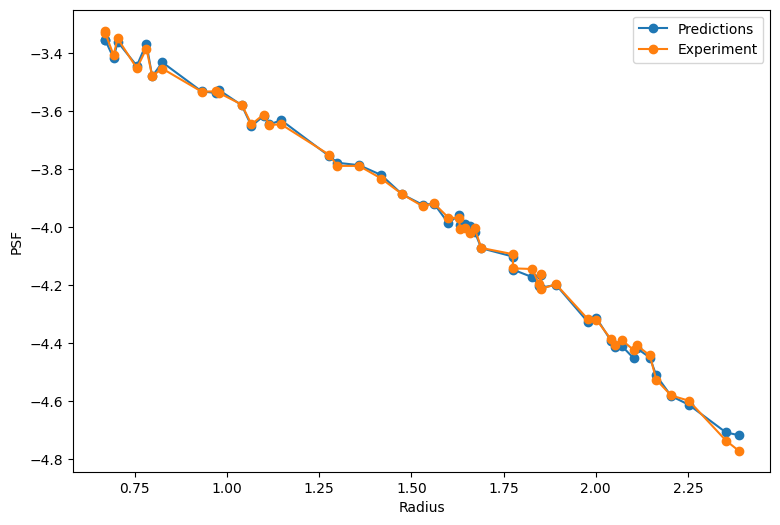

In [ ]:
df_preds = build_pred_df(y_test, preds, radii)
draw_psf(df_preds)

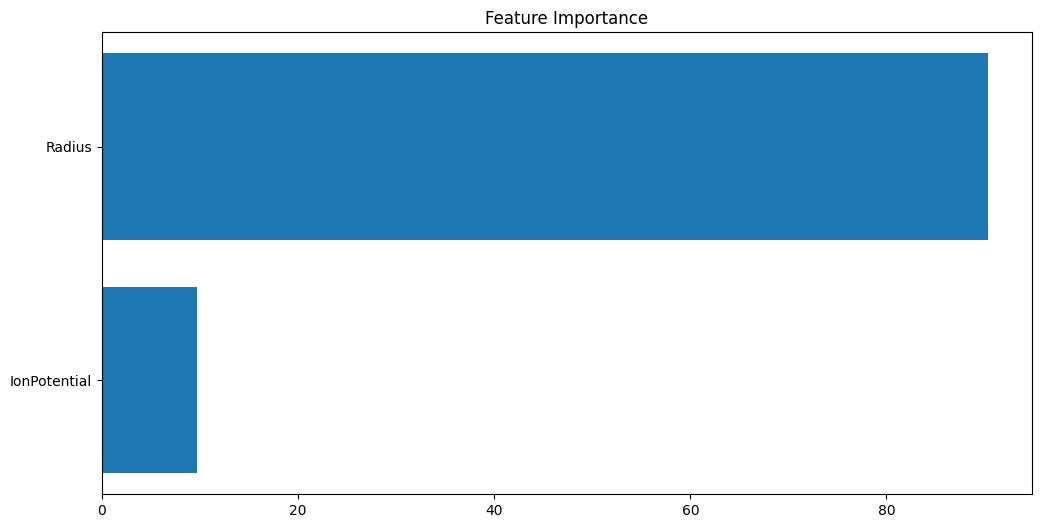

In [ ]:
draw_feature_importance(model)

In [ ]:
numeric_columns = ['Radius', 'IonPotential']
df_nbase = df_n.drop(['alpha', 'beta', 'eta', 'nu1', 'nu2', 'gamma1', 'gamma2'], axis=1)
X_train, X_test, y_train, y_test, scaler, radii = process_single_df(df_nbase, numeric_columns)

rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test, [])

RMSE: 0.118
ARD: 7.58


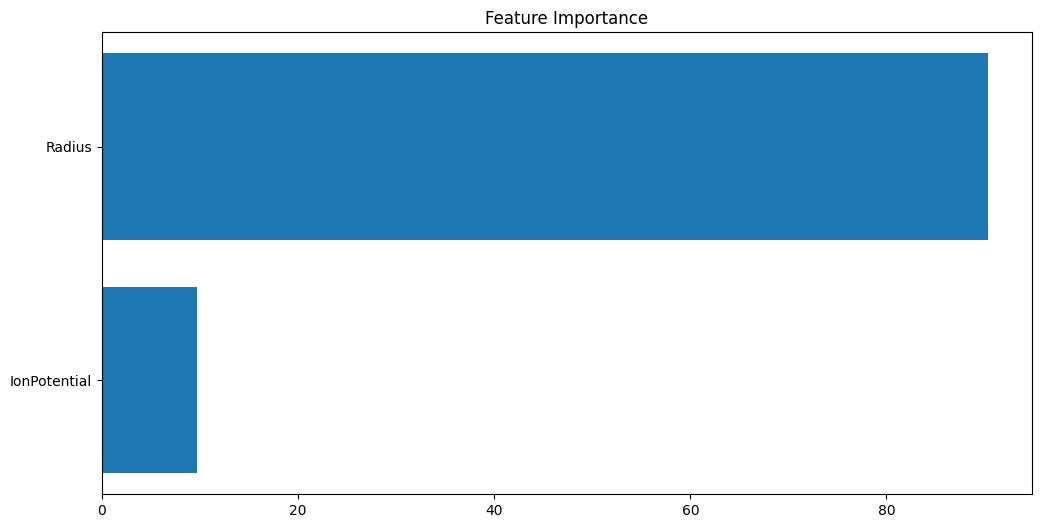

In [ ]:
draw_feature_importance(model)

In [ ]:
numeric_columns = ['Radius', 'alpha', 'beta', 'eta', 'nu1', 'nu2', 'gamma1', 'gamma2']
df_nbase = df_n.drop(['IonPotential'], axis=1)
X_train, X_test, y_train, y_test, scaler, radii = process_single_df(df_nbase, numeric_columns)

rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test, [])

RMSE: 0.125
ARD: 8.19


In [ ]:
numeric_columns = ['Radius', 'IonPotential', 'beta', 'eta', 'gamma1', 'gamma2']
df_nbase = df_n.drop(['alpha', 'nu1', 'nu2'], axis=1)
X_train, X_test, y_train, y_test, scaler, radii = process_single_df(df_nbase, numeric_columns)

rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test, [])

RMSE: 0.117
ARD: 6.9


In [ ]:
numeric_columns = ['Radius', 'IonPotential', 'alpha']
df_nbase = df_n.drop(['beta', 'nu1', 'nu2', 'eta', 'gamma1', 'gamma2'], axis=1)
X_train, X_test, y_train, y_test, scaler, radii = process_single_df(df_nbase, numeric_columns)

rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test, [])

RMSE: 0.116
ARD: 7.02


In [ ]:
df_preds = build_pred_df(y_test, preds, radii)

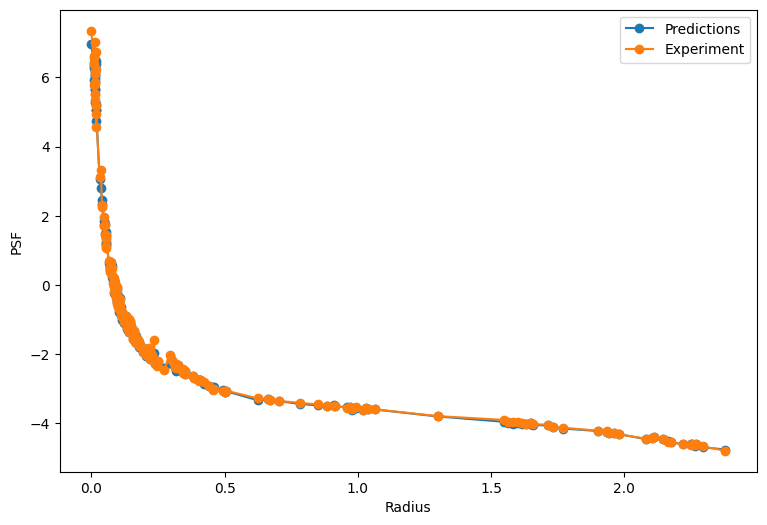

In [ ]:
draw_psf(df_preds)

### Prediction for specific sample

#### Baseline

In [ ]:
test = dfs[4]
train = pd.concat([dfs[0], dfs[2], dfs[3], dfs[1]])
# train = train.drop(['IonPotential'], axis=1)
# test = test.drop(['IonPotential'], axis=1)

In [ ]:
numeric_columns = ['Radius', 'IonPotential','alpha', 'beta', 'eta', 'nu1', 'nu2', 'gamma1', 'gamma2']
X_train, X_test, y_train, y_test, scaler, radii = prepare_dopant_data(train, test, numeric_columns)

In [ ]:
rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test, [])

RMSE: 0.324
ARD: 39.4


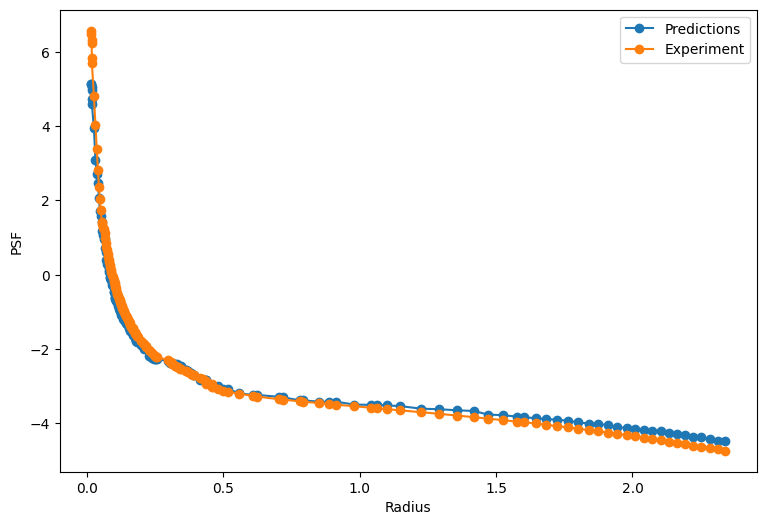

In [ ]:
df_preds = build_pred_df(y_test, preds, radii)
draw_psf(df_preds)

In [ ]:
df_n = pd.concat(dfs)
df_n2 = df_n.drop(['IonPotential'], axis=1)
X_train, X_test, y_train, y_test, scaler, radii = process_single_df(df_n2, numeric_columns)

In [ ]:
rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test, [])

RMSE: 0.125
ARD: 8.19


#### Catboost

In [ ]:
files_names_u = ['ya_d6u.csv', 'ya_d7u.csv', 'ya_d11u.csv', 'ya_d12u.csv', 'ya_d18u.csv']
test = dfs[1]
train = pd.concat([dfs[0], dfs[2], dfs[3], dfs[4]])

In [ ]:
numeric_columns = ['Radius', 'IonPotential']
X_train, X_test, y_train, y_test, scaler, radii = prepare_dopant_data(train, test, numeric_columns)

In [ ]:
rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test, [])

RMSE: 0.873
ARD: 59.3


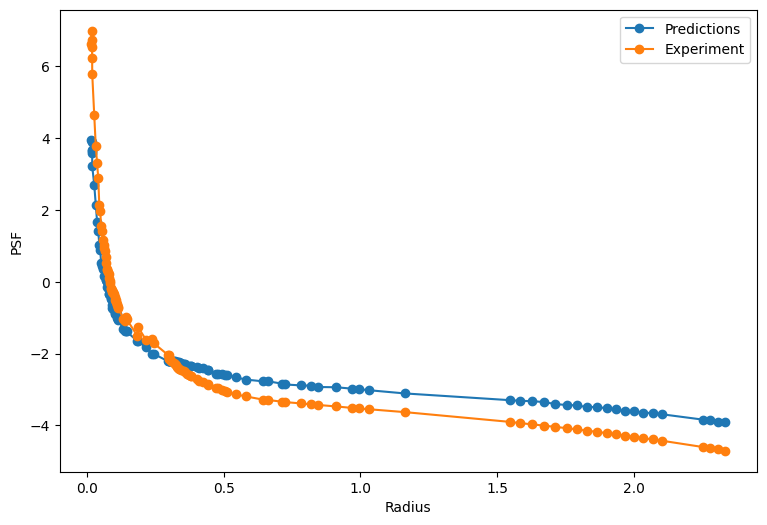

In [ ]:
df_preds = build_pred_df(y_test, preds, radii)
draw_psf(df_preds)

In [ ]:
files_names_u = ['ya_d6u.csv', 'ya_d7u.csv', 'ya_d11u.csv', 'ya_d12u.csv', 'ya_d18u.csv']
test = dfs[4]
train = pd.concat([dfs[0], dfs[2], dfs[3], dfs[1]])
numeric_columns = ['Radius', 'IonPotential']
X_train, X_test, y_train, y_test, scaler, radii = prepare_dopant_data(train, test, numeric_columns)

In [ ]:
rmse, ard, preds, model = train_and_predict(X_train, X_test, y_train, y_test, [])

RMSE: 0.479
ARD: 69.6


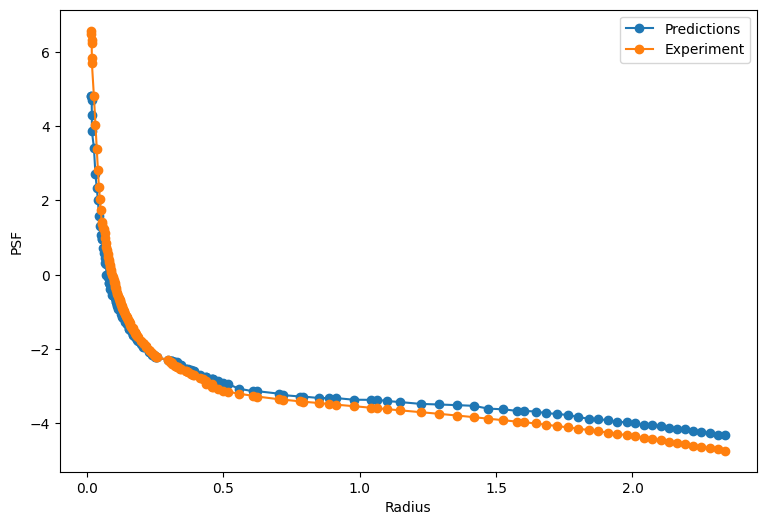

In [ ]:
df_preds = build_pred_df(y_test, preds, radii)
draw_psf(df_preds)